# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='images/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets
import torchvision.models as models

from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
data_dir = './flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [3]:
# TODO: Define your transforms for the training and validation sets
train_transforms =  transforms.Compose([transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=45),
                                        transforms.RandomResizedCrop(size=224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                             std=(0.229, 0.224, 0.225))])
valid_transforms =  transforms.Compose([transforms.Resize(size=256),
                                        transforms.CenterCrop(size=224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                             std=(0.229, 0.224, 0.225))])

# TODO: Load the datasets with ImageFolder
train_image_dataset = torchvision.datasets.ImageFolder(root=train_dir,
                                                       transform=train_transforms)
valid_image_dataset = torchvision.datasets.ImageFolder(root=valid_dir,
                                                       transform=valid_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_dataloader = DataLoader(dataset=train_image_dataset,
                              batch_size=32,
                              shuffle=True,
                              num_workers=0)

valid_dataloader = DataLoader(dataset=valid_image_dataset,
                              batch_size=32,
                              shuffle=True,
                              num_workers=0)

In [4]:
class_to_idx  = train_image_dataset.class_to_idx

In [5]:
# Obtain one batch of training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

In [6]:
images.shape

(32, 3, 224, 224)

In [7]:
img = images[0, :, :, :]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


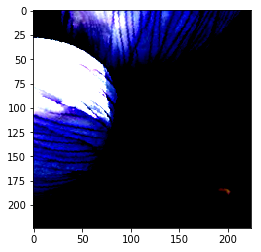

In [8]:
plt.imshow(np.transpose(a=img, axes=(1, 2, 0)))

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [10]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [11]:
# TODO: Build and train your network
def build_model(class_to_idx):
    model = models.resnet18(pretrained=True)

    # Freezing the features
    for param in model.parameters():
        param.requires_grad_(False)
    from collections import OrderedDict

    model.fc = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(512, 512)),
            ('relu', nn.ReLU()),
            ('fc2', nn.Linear(512, 102)),
            ('output', nn.LogSoftmax(dim=1))

           ]))

    # Setting trainable parameters
    for trainable_params in model.fc.parameters():
        trainable_params.requires_grad_(True)
    model.class_to_idx = class_to_idx
    print('Model created!')
    return model


In [12]:
model = build_model(class_to_idx=class_to_idx)

Model created!


In [13]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    model.cuda()

In [14]:
train_on_gpu

True

In [15]:
# Specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# Specify optimizer
learning_rate = 0.0001
optimizer = optim.Adam(params=model.fc.parameters(),
                       lr=learning_rate)

In [16]:
from tqdm import tqdm_notebook as tqdm

In [17]:
best_weights_path = './models/lab_best_model_state_dict.pth'

In [18]:
# Number of epochs to train the model
n_epochs = 1000

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs + 1):

    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model
    model.train()
    for data, target in tqdm(train_dataloader):
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item() * data.size(0)
          
    # Validate the model
    model.eval()
    for data, target in valid_dataloader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss 
        valid_loss += loss.item() * data.size(0)
    
    # Calculate average losses
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(valid_dataloader.dataset)
        
    # Print training / validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), best_weights_path)
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 4.175992 	Validation Loss: 3.509977
Validation loss decreased (inf --> 3.509977).  Saving model ...



Epoch: 2 	Training Loss: 3.193785 	Validation Loss: 2.479796
Validation loss decreased (3.509977 --> 2.479796).  Saving model ...



Epoch: 3 	Training Loss: 2.421441 	Validation Loss: 1.759117
Validation loss decreased (2.479796 --> 1.759117).  Saving model ...



Epoch: 4 	Training Loss: 1.905929 	Validation Loss: 1.332333
Validation loss decreased (1.759117 --> 1.332333).  Saving model ...



Epoch: 5 	Training Loss: 1.552519 	Validation Loss: 1.049589
Validation loss decreased (1.332333 --> 1.049589).  Saving model ...



Epoch: 6 	Training Loss: 1.352600 	Validation Loss: 0.875471
Validation loss decreased (1.049589 --> 0.875471).  Saving model ...



Epoch: 7 	Training Loss: 1.195973 	Validation Loss: 0.732373
Validation loss decreased (0.875471 --> 0.732373).  Saving model ...



Epoch: 8 	Training Loss: 1.048971 	Validation Loss: 0.656680
Validation loss decreased (0.732373 --> 0.656680).  Saving model ...



Epoch: 9 	Training Loss: 0.992780 	Validation Loss: 0.557957
Validation loss decreased (0.656680 --> 0.557957).  Saving model ...



Epoch: 10 	Training Loss: 0.927731 	Validation Loss: 0.524920
Validation loss decreased (0.557957 --> 0.524920).  Saving model ...



Epoch: 11 	Training Loss: 0.841716 	Validation Loss: 0.501692
Validation loss decreased (0.524920 --> 0.501692).  Saving model ...



Epoch: 12 	Training Loss: 0.806561 	Validation Loss: 0.449727
Validation loss decreased (0.501692 --> 0.449727).  Saving model ...



Epoch: 13 	Training Loss: 0.762560 	Validation Loss: 0.431978
Validation loss decreased (0.449727 --> 0.431978).  Saving model ...



Epoch: 14 	Training Loss: 0.742772 	Validation Loss: 0.412217
Validation loss decreased (0.431978 --> 0.412217).  Saving model ...



Epoch: 15 	Training Loss: 0.695902 	Validation Loss: 0.384696
Validation loss decreased (0.412217 --> 0.384696).  Saving model ...



Epoch: 16 	Training Loss: 0.671293 	Validation Loss: 0.390143



Epoch: 17 	Training Loss: 0.649492 	Validation Loss: 0.367097
Validation loss decreased (0.384696 --> 0.367097).  Saving model ...



Epoch: 18 	Training Loss: 0.622558 	Validation Loss: 0.352512
Validation loss decreased (0.367097 --> 0.352512).  Saving model ...



Epoch: 19 	Training Loss: 0.609280 	Validation Loss: 0.327045
Validation loss decreased (0.352512 --> 0.327045).  Saving model ...



Epoch: 20 	Training Loss: 0.618464 	Validation Loss: 0.311618
Validation loss decreased (0.327045 --> 0.311618).  Saving model ...



Epoch: 21 	Training Loss: 0.580098 	Validation Loss: 0.317111



Epoch: 22 	Training Loss: 0.558698 	Validation Loss: 0.309712
Validation loss decreased (0.311618 --> 0.309712).  Saving model ...



Epoch: 23 	Training Loss: 0.577755 	Validation Loss: 0.294099
Validation loss decreased (0.309712 --> 0.294099).  Saving model ...



Epoch: 24 	Training Loss: 0.526564 	Validation Loss: 0.292421
Validation loss decreased (0.294099 --> 0.292421).  Saving model ...



Epoch: 25 	Training Loss: 0.534518 	Validation Loss: 0.285503
Validation loss decreased (0.292421 --> 0.285503).  Saving model ...



Epoch: 26 	Training Loss: 0.523107 	Validation Loss: 0.289981



Epoch: 27 	Training Loss: 0.504274 	Validation Loss: 0.269414
Validation loss decreased (0.285503 --> 0.269414).  Saving model ...



Epoch: 28 	Training Loss: 0.505882 	Validation Loss: 0.273360



Epoch: 29 	Training Loss: 0.507347 	Validation Loss: 0.266702
Validation loss decreased (0.269414 --> 0.266702).  Saving model ...



Epoch: 30 	Training Loss: 0.507867 	Validation Loss: 0.269696



Epoch: 31 	Training Loss: 0.507768 	Validation Loss: 0.274473



Epoch: 32 	Training Loss: 0.476488 	Validation Loss: 0.247999
Validation loss decreased (0.266702 --> 0.247999).  Saving model ...



Epoch: 33 	Training Loss: 0.481602 	Validation Loss: 0.242728
Validation loss decreased (0.247999 --> 0.242728).  Saving model ...



Epoch: 34 	Training Loss: 0.450375 	Validation Loss: 0.253811



Epoch: 35 	Training Loss: 0.457862 	Validation Loss: 0.247623



Epoch: 36 	Training Loss: 0.482778 	Validation Loss: 0.235116
Validation loss decreased (0.242728 --> 0.235116).  Saving model ...



Epoch: 37 	Training Loss: 0.459516 	Validation Loss: 0.233579
Validation loss decreased (0.235116 --> 0.233579).  Saving model ...



Epoch: 38 	Training Loss: 0.441305 	Validation Loss: 0.238725



Epoch: 39 	Training Loss: 0.447667 	Validation Loss: 0.229706
Validation loss decreased (0.233579 --> 0.229706).  Saving model ...



Epoch: 40 	Training Loss: 0.434666 	Validation Loss: 0.233171



Epoch: 41 	Training Loss: 0.439800 	Validation Loss: 0.226232
Validation loss decreased (0.229706 --> 0.226232).  Saving model ...



Epoch: 42 	Training Loss: 0.419273 	Validation Loss: 0.225893
Validation loss decreased (0.226232 --> 0.225893).  Saving model ...



Epoch: 43 	Training Loss: 0.419307 	Validation Loss: 0.240893



Epoch: 44 	Training Loss: 0.438066 	Validation Loss: 0.217169
Validation loss decreased (0.225893 --> 0.217169).  Saving model ...



Epoch: 45 	Training Loss: 0.400678 	Validation Loss: 0.230420



Epoch: 46 	Training Loss: 0.413377 	Validation Loss: 0.240117



Epoch: 47 	Training Loss: 0.390602 	Validation Loss: 0.224500



Epoch: 48 	Training Loss: 0.405114 	Validation Loss: 0.218515



Epoch: 49 	Training Loss: 0.378712 	Validation Loss: 0.222820



Epoch: 50 	Training Loss: 0.394278 	Validation Loss: 0.218264



Epoch: 51 	Training Loss: 0.388326 	Validation Loss: 0.230403



Epoch: 52 	Training Loss: 0.394968 	Validation Loss: 0.225580



Epoch: 53 	Training Loss: 0.407868 	Validation Loss: 0.219476



Epoch: 54 	Training Loss: 0.397970 	Validation Loss: 0.212288
Validation loss decreased (0.217169 --> 0.212288).  Saving model ...



Epoch: 55 	Training Loss: 0.384515 	Validation Loss: 0.221526



Epoch: 56 	Training Loss: 0.390018 	Validation Loss: 0.213489



Epoch: 57 	Training Loss: 0.385213 	Validation Loss: 0.215406



Epoch: 58 	Training Loss: 0.384309 	Validation Loss: 0.216063



Epoch: 59 	Training Loss: 0.397734 	Validation Loss: 0.206224
Validation loss decreased (0.212288 --> 0.206224).  Saving model ...



Epoch: 60 	Training Loss: 0.375814 	Validation Loss: 0.214966



Epoch: 61 	Training Loss: 0.373933 	Validation Loss: 0.210128



Epoch: 62 	Training Loss: 0.379864 	Validation Loss: 0.205413
Validation loss decreased (0.206224 --> 0.205413).  Saving model ...



Epoch: 63 	Training Loss: 0.361123 	Validation Loss: 0.199218
Validation loss decreased (0.205413 --> 0.199218).  Saving model ...



Epoch: 64 	Training Loss: 0.365674 	Validation Loss: 0.212098



Epoch: 65 	Training Loss: 0.363764 	Validation Loss: 0.200215



Epoch: 66 	Training Loss: 0.364853 	Validation Loss: 0.215205



Epoch: 67 	Training Loss: 0.361002 	Validation Loss: 0.203207



Epoch: 68 	Training Loss: 0.358863 	Validation Loss: 0.206620



Epoch: 69 	Training Loss: 0.352368 	Validation Loss: 0.206177



Epoch: 70 	Training Loss: 0.349149 	Validation Loss: 0.214628



Epoch: 71 	Training Loss: 0.361181 	Validation Loss: 0.204008



Epoch: 72 	Training Loss: 0.358308 	Validation Loss: 0.206740



Epoch: 73 	Training Loss: 0.347026 	Validation Loss: 0.193432
Validation loss decreased (0.199218 --> 0.193432).  Saving model ...



Epoch: 74 	Training Loss: 0.341486 	Validation Loss: 0.207927



Epoch: 75 	Training Loss: 0.356949 	Validation Loss: 0.208520



Epoch: 76 	Training Loss: 0.355241 	Validation Loss: 0.195614



Epoch: 77 	Training Loss: 0.343751 	Validation Loss: 0.218450



Epoch: 78 	Training Loss: 0.344208 	Validation Loss: 0.221906



Epoch: 79 	Training Loss: 0.356882 	Validation Loss: 0.201883



Epoch: 80 	Training Loss: 0.339744 	Validation Loss: 0.201316



Epoch: 81 	Training Loss: 0.322519 	Validation Loss: 0.210845



Epoch: 82 	Training Loss: 0.356813 	Validation Loss: 0.211224



Epoch: 83 	Training Loss: 0.328897 	Validation Loss: 0.204861



Epoch: 84 	Training Loss: 0.339630 	Validation Loss: 0.203041



Epoch: 85 	Training Loss: 0.327501 	Validation Loss: 0.201109



Epoch: 86 	Training Loss: 0.341961 	Validation Loss: 0.207867



Epoch: 87 	Training Loss: 0.341474 	Validation Loss: 0.200717



Epoch: 88 	Training Loss: 0.336776 	Validation Loss: 0.192015
Validation loss decreased (0.193432 --> 0.192015).  Saving model ...



Epoch: 89 	Training Loss: 0.322234 	Validation Loss: 0.192892



Epoch: 90 	Training Loss: 0.318689 	Validation Loss: 0.206816



Epoch: 91 	Training Loss: 0.313711 	Validation Loss: 0.207311



Epoch: 92 	Training Loss: 0.334416 	Validation Loss: 0.200230



Epoch: 93 	Training Loss: 0.313175 	Validation Loss: 0.198127



Epoch: 94 	Training Loss: 0.327618 	Validation Loss: 0.192983



Epoch: 95 	Training Loss: 0.311003 	Validation Loss: 0.188966
Validation loss decreased (0.192015 --> 0.188966).  Saving model ...



Epoch: 96 	Training Loss: 0.314323 	Validation Loss: 0.189256



Epoch: 97 	Training Loss: 0.316925 	Validation Loss: 0.196462



Epoch: 98 	Training Loss: 0.342905 	Validation Loss: 0.199628



Epoch: 99 	Training Loss: 0.303067 	Validation Loss: 0.206056



Epoch: 100 	Training Loss: 0.321398 	Validation Loss: 0.205868



Epoch: 101 	Training Loss: 0.312826 	Validation Loss: 0.195635



Epoch: 102 	Training Loss: 0.307094 	Validation Loss: 0.199848



Epoch: 103 	Training Loss: 0.292862 	Validation Loss: 0.199119



Epoch: 104 	Training Loss: 0.322376 	Validation Loss: 0.204865



Epoch: 105 	Training Loss: 0.322630 	Validation Loss: 0.191695



Epoch: 106 	Training Loss: 0.294445 	Validation Loss: 0.195104



Epoch: 107 	Training Loss: 0.322496 	Validation Loss: 0.202620



Epoch: 108 	Training Loss: 0.303855 	Validation Loss: 0.197934



Epoch: 109 	Training Loss: 0.317055 	Validation Loss: 0.195558



Epoch: 110 	Training Loss: 0.304378 	Validation Loss: 0.204902



Epoch: 111 	Training Loss: 0.312458 	Validation Loss: 0.199585



Epoch: 112 	Training Loss: 0.311747 	Validation Loss: 0.195869



Epoch: 113 	Training Loss: 0.312047 	Validation Loss: 0.186362
Validation loss decreased (0.188966 --> 0.186362).  Saving model ...



Epoch: 114 	Training Loss: 0.322025 	Validation Loss: 0.181761
Validation loss decreased (0.186362 --> 0.181761).  Saving model ...



Epoch: 115 	Training Loss: 0.314075 	Validation Loss: 0.192861



Epoch: 116 	Training Loss: 0.306247 	Validation Loss: 0.184519



Epoch: 117 	Training Loss: 0.302171 	Validation Loss: 0.186114



Epoch: 118 	Training Loss: 0.312418 	Validation Loss: 0.191830



Epoch: 119 	Training Loss: 0.306276 	Validation Loss: 0.185497



Epoch: 120 	Training Loss: 0.302538 	Validation Loss: 0.184483



Epoch: 121 	Training Loss: 0.290869 	Validation Loss: 0.178433
Validation loss decreased (0.181761 --> 0.178433).  Saving model ...



Epoch: 122 	Training Loss: 0.279756 	Validation Loss: 0.186546



Epoch: 123 	Training Loss: 0.297528 	Validation Loss: 0.190626



Epoch: 124 	Training Loss: 0.302555 	Validation Loss: 0.184846



Epoch: 125 	Training Loss: 0.313359 	Validation Loss: 0.181636



Epoch: 126 	Training Loss: 0.297239 	Validation Loss: 0.189480



Epoch: 127 	Training Loss: 0.303551 	Validation Loss: 0.196568



Epoch: 128 	Training Loss: 0.288098 	Validation Loss: 0.204257



Epoch: 129 	Training Loss: 0.303279 	Validation Loss: 0.186743



Epoch: 130 	Training Loss: 0.295264 	Validation Loss: 0.186142



Epoch: 131 	Training Loss: 0.288666 	Validation Loss: 0.183366



Epoch: 132 	Training Loss: 0.285705 	Validation Loss: 0.183930



Epoch: 133 	Training Loss: 0.303507 	Validation Loss: 0.194701



Epoch: 134 	Training Loss: 0.287956 	Validation Loss: 0.178462



Epoch: 135 	Training Loss: 0.303381 	Validation Loss: 0.200846



Epoch: 136 	Training Loss: 0.279739 	Validation Loss: 0.196263



Epoch: 137 	Training Loss: 0.283991 	Validation Loss: 0.197281



Epoch: 138 	Training Loss: 0.296860 	Validation Loss: 0.188589



Epoch: 139 	Training Loss: 0.293616 	Validation Loss: 0.193772



Epoch: 140 	Training Loss: 0.282679 	Validation Loss: 0.208078



Epoch: 141 	Training Loss: 0.274648 	Validation Loss: 0.192573



Epoch: 142 	Training Loss: 0.286936 	Validation Loss: 0.191573



Epoch: 143 	Training Loss: 0.309424 	Validation Loss: 0.195866



Epoch: 144 	Training Loss: 0.270053 	Validation Loss: 0.196510



Epoch: 145 	Training Loss: 0.272924 	Validation Loss: 0.185507



Epoch: 146 	Training Loss: 0.281516 	Validation Loss: 0.189773



Epoch: 147 	Training Loss: 0.294865 	Validation Loss: 0.181832



Epoch: 148 	Training Loss: 0.278636 	Validation Loss: 0.198048



Epoch: 149 	Training Loss: 0.266486 	Validation Loss: 0.196763



Epoch: 150 	Training Loss: 0.279190 	Validation Loss: 0.196491



Epoch: 151 	Training Loss: 0.292715 	Validation Loss: 0.190022



Epoch: 152 	Training Loss: 0.289588 	Validation Loss: 0.192803



Epoch: 153 	Training Loss: 0.269961 	Validation Loss: 0.198981



Epoch: 154 	Training Loss: 0.266553 	Validation Loss: 0.192524



Epoch: 155 	Training Loss: 0.261194 	Validation Loss: 0.193316



Epoch: 156 	Training Loss: 0.283518 	Validation Loss: 0.193858



Epoch: 157 	Training Loss: 0.276577 	Validation Loss: 0.194403



Epoch: 158 	Training Loss: 0.279230 	Validation Loss: 0.198034



Epoch: 159 	Training Loss: 0.297175 	Validation Loss: 0.194930



Epoch: 160 	Training Loss: 0.266369 	Validation Loss: 0.193333



Epoch: 161 	Training Loss: 0.282803 	Validation Loss: 0.202999



Epoch: 162 	Training Loss: 0.298599 	Validation Loss: 0.190830



Epoch: 163 	Training Loss: 0.268861 	Validation Loss: 0.190206



Epoch: 164 	Training Loss: 0.262534 	Validation Loss: 0.191806



Epoch: 165 	Training Loss: 0.287958 	Validation Loss: 0.197630



Epoch: 166 	Training Loss: 0.270440 	Validation Loss: 0.201247



Epoch: 167 	Training Loss: 0.283047 	Validation Loss: 0.190421



Epoch: 168 	Training Loss: 0.273575 	Validation Loss: 0.183979



Epoch: 169 	Training Loss: 0.279343 	Validation Loss: 0.191611



Epoch: 170 	Training Loss: 0.261919 	Validation Loss: 0.197438



Epoch: 171 	Training Loss: 0.281899 	Validation Loss: 0.203484



Epoch: 172 	Training Loss: 0.265863 	Validation Loss: 0.191426



Epoch: 173 	Training Loss: 0.278764 	Validation Loss: 0.189741



Epoch: 174 	Training Loss: 0.253252 	Validation Loss: 0.196637



Epoch: 175 	Training Loss: 0.273667 	Validation Loss: 0.198401



Epoch: 176 	Training Loss: 0.268178 	Validation Loss: 0.197168



Epoch: 177 	Training Loss: 0.265405 	Validation Loss: 0.194884



Epoch: 178 	Training Loss: 0.256526 	Validation Loss: 0.196027



Epoch: 179 	Training Loss: 0.268211 	Validation Loss: 0.203530



Epoch: 180 	Training Loss: 0.270536 	Validation Loss: 0.208180



Epoch: 181 	Training Loss: 0.264768 	Validation Loss: 0.189739



Epoch: 182 	Training Loss: 0.247430 	Validation Loss: 0.207589



Epoch: 183 	Training Loss: 0.291339 	Validation Loss: 0.188567



Epoch: 184 	Training Loss: 0.282043 	Validation Loss: 0.190478



Epoch: 185 	Training Loss: 0.261349 	Validation Loss: 0.207484



Epoch: 186 	Training Loss: 0.272713 	Validation Loss: 0.206488



Epoch: 187 	Training Loss: 0.248035 	Validation Loss: 0.198288



Epoch: 188 	Training Loss: 0.262895 	Validation Loss: 0.185879



Epoch: 189 	Training Loss: 0.257676 	Validation Loss: 0.181765



Epoch: 190 	Training Loss: 0.271914 	Validation Loss: 0.180323



Epoch: 191 	Training Loss: 0.273677 	Validation Loss: 0.195850



Epoch: 192 	Training Loss: 0.251271 	Validation Loss: 0.201335



Epoch: 193 	Training Loss: 0.231531 	Validation Loss: 0.190954



Epoch: 194 	Training Loss: 0.258955 	Validation Loss: 0.204737



Epoch: 195 	Training Loss: 0.277374 	Validation Loss: 0.192363



Epoch: 196 	Training Loss: 0.254428 	Validation Loss: 0.198602



Epoch: 197 	Training Loss: 0.260764 	Validation Loss: 0.202321



Epoch: 198 	Training Loss: 0.232989 	Validation Loss: 0.194041



Epoch: 199 	Training Loss: 0.252111 	Validation Loss: 0.201295



Epoch: 200 	Training Loss: 0.259198 	Validation Loss: 0.197156



Epoch: 201 	Training Loss: 0.229874 	Validation Loss: 0.201245



Epoch: 202 	Training Loss: 0.276892 	Validation Loss: 0.206205



Epoch: 203 	Training Loss: 0.253281 	Validation Loss: 0.213275



Epoch: 204 	Training Loss: 0.258526 	Validation Loss: 0.205443



Epoch: 205 	Training Loss: 0.257803 	Validation Loss: 0.184669



Epoch: 206 	Training Loss: 0.240975 	Validation Loss: 0.193259



Epoch: 207 	Training Loss: 0.241695 	Validation Loss: 0.200802



Epoch: 208 	Training Loss: 0.251908 	Validation Loss: 0.197526



Epoch: 209 	Training Loss: 0.271509 	Validation Loss: 0.197763



Epoch: 210 	Training Loss: 0.249461 	Validation Loss: 0.208500



Epoch: 211 	Training Loss: 0.258193 	Validation Loss: 0.192946



Epoch: 212 	Training Loss: 0.266889 	Validation Loss: 0.188166



Epoch: 213 	Training Loss: 0.257339 	Validation Loss: 0.184654



Epoch: 214 	Training Loss: 0.251106 	Validation Loss: 0.199818



Epoch: 215 	Training Loss: 0.241305 	Validation Loss: 0.201001



Epoch: 216 	Training Loss: 0.263957 	Validation Loss: 0.192655



Epoch: 217 	Training Loss: 0.249715 	Validation Loss: 0.198279



Epoch: 218 	Training Loss: 0.236406 	Validation Loss: 0.193165



Epoch: 219 	Training Loss: 0.273740 	Validation Loss: 0.188891



Epoch: 220 	Training Loss: 0.266587 	Validation Loss: 0.193126



Epoch: 221 	Training Loss: 0.241684 	Validation Loss: 0.194972



Epoch: 222 	Training Loss: 0.256728 	Validation Loss: 0.204777



Epoch: 223 	Training Loss: 0.236907 	Validation Loss: 0.203990



Epoch: 224 	Training Loss: 0.234786 	Validation Loss: 0.200990



Epoch: 225 	Training Loss: 0.249606 	Validation Loss: 0.192980



Epoch: 226 	Training Loss: 0.245471 	Validation Loss: 0.184066



Epoch: 227 	Training Loss: 0.256804 	Validation Loss: 0.193977



Epoch: 228 	Training Loss: 0.249169 	Validation Loss: 0.187862



Epoch: 229 	Training Loss: 0.249225 	Validation Loss: 0.196165



Epoch: 230 	Training Loss: 0.246613 	Validation Loss: 0.203336



Epoch: 231 	Training Loss: 0.274793 	Validation Loss: 0.185058



Epoch: 232 	Training Loss: 0.249729 	Validation Loss: 0.194310



Epoch: 233 	Training Loss: 0.249385 	Validation Loss: 0.206684



Epoch: 234 	Training Loss: 0.248417 	Validation Loss: 0.191421



Epoch: 235 	Training Loss: 0.251085 	Validation Loss: 0.196733



Epoch: 236 	Training Loss: 0.269334 	Validation Loss: 0.202477



Epoch: 237 	Training Loss: 0.225586 	Validation Loss: 0.194852



Epoch: 238 	Training Loss: 0.244561 	Validation Loss: 0.196550



Epoch: 239 	Training Loss: 0.234171 	Validation Loss: 0.191640



Epoch: 240 	Training Loss: 0.234318 	Validation Loss: 0.189097



Epoch: 241 	Training Loss: 0.226122 	Validation Loss: 0.181460



Epoch: 242 	Training Loss: 0.248170 	Validation Loss: 0.187623



Epoch: 243 	Training Loss: 0.226641 	Validation Loss: 0.204752



Epoch: 244 	Training Loss: 0.249209 	Validation Loss: 0.176230
Validation loss decreased (0.178433 --> 0.176230).  Saving model ...



Epoch: 245 	Training Loss: 0.236637 	Validation Loss: 0.194965



Epoch: 246 	Training Loss: 0.218056 	Validation Loss: 0.186604



Epoch: 247 	Training Loss: 0.240774 	Validation Loss: 0.187474



Epoch: 248 	Training Loss: 0.245316 	Validation Loss: 0.187114



Epoch: 249 	Training Loss: 0.249617 	Validation Loss: 0.188703



Epoch: 250 	Training Loss: 0.235684 	Validation Loss: 0.187199



Epoch: 251 	Training Loss: 0.242314 	Validation Loss: 0.200676



Epoch: 252 	Training Loss: 0.251959 	Validation Loss: 0.185443



Epoch: 253 	Training Loss: 0.229963 	Validation Loss: 0.187868



Epoch: 254 	Training Loss: 0.241186 	Validation Loss: 0.191224



Epoch: 255 	Training Loss: 0.231811 	Validation Loss: 0.188407



Epoch: 256 	Training Loss: 0.235924 	Validation Loss: 0.201563



Epoch: 257 	Training Loss: 0.250880 	Validation Loss: 0.184936



Epoch: 258 	Training Loss: 0.212985 	Validation Loss: 0.190510



Epoch: 259 	Training Loss: 0.239169 	Validation Loss: 0.189508



Epoch: 260 	Training Loss: 0.236772 	Validation Loss: 0.204017



Epoch: 261 	Training Loss: 0.244210 	Validation Loss: 0.196629



Epoch: 262 	Training Loss: 0.243084 	Validation Loss: 0.217994



Epoch: 263 	Training Loss: 0.229738 	Validation Loss: 0.194314



Epoch: 264 	Training Loss: 0.236772 	Validation Loss: 0.194886



Epoch: 265 	Training Loss: 0.236906 	Validation Loss: 0.191450



Epoch: 266 	Training Loss: 0.245108 	Validation Loss: 0.201206



Epoch: 267 	Training Loss: 0.245280 	Validation Loss: 0.212061



Epoch: 268 	Training Loss: 0.226630 	Validation Loss: 0.192728



Epoch: 269 	Training Loss: 0.243209 	Validation Loss: 0.204096



Epoch: 270 	Training Loss: 0.244158 	Validation Loss: 0.206529



Epoch: 271 	Training Loss: 0.224122 	Validation Loss: 0.206898



Epoch: 272 	Training Loss: 0.230680 	Validation Loss: 0.203473



Epoch: 273 	Training Loss: 0.241913 	Validation Loss: 0.209439



Epoch: 274 	Training Loss: 0.231780 	Validation Loss: 0.197726



Epoch: 275 	Training Loss: 0.244842 	Validation Loss: 0.190349



Epoch: 276 	Training Loss: 0.229739 	Validation Loss: 0.210454



Epoch: 277 	Training Loss: 0.229833 	Validation Loss: 0.191601



Epoch: 278 	Training Loss: 0.246949 	Validation Loss: 0.197436



Epoch: 279 	Training Loss: 0.234289 	Validation Loss: 0.194900



Epoch: 280 	Training Loss: 0.225548 	Validation Loss: 0.200875



Epoch: 281 	Training Loss: 0.245491 	Validation Loss: 0.209123



Epoch: 282 	Training Loss: 0.222903 	Validation Loss: 0.200986



Epoch: 283 	Training Loss: 0.220903 	Validation Loss: 0.200414



Epoch: 284 	Training Loss: 0.232369 	Validation Loss: 0.210181



Epoch: 285 	Training Loss: 0.230091 	Validation Loss: 0.201461



Epoch: 286 	Training Loss: 0.241317 	Validation Loss: 0.213405



Epoch: 287 	Training Loss: 0.232568 	Validation Loss: 0.200224



Epoch: 288 	Training Loss: 0.231215 	Validation Loss: 0.206422



Epoch: 289 	Training Loss: 0.237122 	Validation Loss: 0.205202



Epoch: 290 	Training Loss: 0.223088 	Validation Loss: 0.193903



Epoch: 291 	Training Loss: 0.233206 	Validation Loss: 0.195876



Epoch: 292 	Training Loss: 0.236583 	Validation Loss: 0.192622



Epoch: 293 	Training Loss: 0.218642 	Validation Loss: 0.193381



Epoch: 294 	Training Loss: 0.227460 	Validation Loss: 0.199016



Epoch: 295 	Training Loss: 0.226973 	Validation Loss: 0.202575



Epoch: 296 	Training Loss: 0.237329 	Validation Loss: 0.195521



Epoch: 297 	Training Loss: 0.233810 	Validation Loss: 0.200327



Epoch: 298 	Training Loss: 0.222967 	Validation Loss: 0.207350



Epoch: 299 	Training Loss: 0.223078 	Validation Loss: 0.197878



Epoch: 300 	Training Loss: 0.223703 	Validation Loss: 0.201962



Epoch: 301 	Training Loss: 0.214054 	Validation Loss: 0.199138



Epoch: 302 	Training Loss: 0.223398 	Validation Loss: 0.197504



Epoch: 303 	Training Loss: 0.211908 	Validation Loss: 0.202455



Epoch: 304 	Training Loss: 0.245913 	Validation Loss: 0.201183



Epoch: 305 	Training Loss: 0.221565 	Validation Loss: 0.190471



Epoch: 306 	Training Loss: 0.233000 	Validation Loss: 0.208431



Epoch: 307 	Training Loss: 0.207921 	Validation Loss: 0.198425



Epoch: 308 	Training Loss: 0.232059 	Validation Loss: 0.195062



Epoch: 309 	Training Loss: 0.230816 	Validation Loss: 0.214017



Epoch: 310 	Training Loss: 0.218975 	Validation Loss: 0.195317



Epoch: 311 	Training Loss: 0.215973 	Validation Loss: 0.198652



Epoch: 312 	Training Loss: 0.222444 	Validation Loss: 0.194084



Epoch: 313 	Training Loss: 0.229862 	Validation Loss: 0.203080



Epoch: 314 	Training Loss: 0.219746 	Validation Loss: 0.194169



Epoch: 315 	Training Loss: 0.211701 	Validation Loss: 0.185291



Epoch: 316 	Training Loss: 0.223132 	Validation Loss: 0.194271



Epoch: 317 	Training Loss: 0.219659 	Validation Loss: 0.196175



Epoch: 318 	Training Loss: 0.218918 	Validation Loss: 0.189190



Epoch: 319 	Training Loss: 0.206309 	Validation Loss: 0.216088



Epoch: 320 	Training Loss: 0.209879 	Validation Loss: 0.197607



Epoch: 321 	Training Loss: 0.210607 	Validation Loss: 0.197338



Epoch: 322 	Training Loss: 0.227205 	Validation Loss: 0.201786



Epoch: 323 	Training Loss: 0.233530 	Validation Loss: 0.199751



Epoch: 324 	Training Loss: 0.202077 	Validation Loss: 0.207599



Epoch: 325 	Training Loss: 0.218714 	Validation Loss: 0.201319



Epoch: 326 	Training Loss: 0.225858 	Validation Loss: 0.204156



Epoch: 327 	Training Loss: 0.239486 	Validation Loss: 0.211682



Epoch: 328 	Training Loss: 0.211955 	Validation Loss: 0.215341



Epoch: 329 	Training Loss: 0.212836 	Validation Loss: 0.202135



Epoch: 330 	Training Loss: 0.216824 	Validation Loss: 0.194597



Epoch: 331 	Training Loss: 0.214094 	Validation Loss: 0.204267



Epoch: 332 	Training Loss: 0.218110 	Validation Loss: 0.192379



Epoch: 333 	Training Loss: 0.202437 	Validation Loss: 0.192680



Epoch: 334 	Training Loss: 0.212813 	Validation Loss: 0.186077



Epoch: 335 	Training Loss: 0.192017 	Validation Loss: 0.202788



Epoch: 336 	Training Loss: 0.221438 	Validation Loss: 0.191890



Epoch: 337 	Training Loss: 0.225205 	Validation Loss: 0.200902



Epoch: 338 	Training Loss: 0.203432 	Validation Loss: 0.196873



Epoch: 339 	Training Loss: 0.213453 	Validation Loss: 0.196034



Epoch: 340 	Training Loss: 0.202255 	Validation Loss: 0.191166



Epoch: 341 	Training Loss: 0.206790 	Validation Loss: 0.189678



Epoch: 342 	Training Loss: 0.206676 	Validation Loss: 0.183727



Epoch: 343 	Training Loss: 0.202544 	Validation Loss: 0.195469



Epoch: 344 	Training Loss: 0.210857 	Validation Loss: 0.187231



Epoch: 345 	Training Loss: 0.210097 	Validation Loss: 0.207685



Epoch: 346 	Training Loss: 0.200310 	Validation Loss: 0.194783



Epoch: 347 	Training Loss: 0.217887 	Validation Loss: 0.202289



Epoch: 348 	Training Loss: 0.211322 	Validation Loss: 0.187631



Epoch: 349 	Training Loss: 0.227126 	Validation Loss: 0.208452



Epoch: 350 	Training Loss: 0.205248 	Validation Loss: 0.196287



Epoch: 351 	Training Loss: 0.229292 	Validation Loss: 0.194415



Epoch: 352 	Training Loss: 0.202714 	Validation Loss: 0.201344



Epoch: 353 	Training Loss: 0.196857 	Validation Loss: 0.186699



Epoch: 354 	Training Loss: 0.215693 	Validation Loss: 0.190248



Epoch: 355 	Training Loss: 0.207379 	Validation Loss: 0.196820



Epoch: 356 	Training Loss: 0.206662 	Validation Loss: 0.194382



Epoch: 357 	Training Loss: 0.213799 	Validation Loss: 0.197337



Epoch: 358 	Training Loss: 0.201885 	Validation Loss: 0.200599



Epoch: 359 	Training Loss: 0.224626 	Validation Loss: 0.209642



Epoch: 360 	Training Loss: 0.230345 	Validation Loss: 0.185774



Epoch: 361 	Training Loss: 0.217888 	Validation Loss: 0.201430



Epoch: 362 	Training Loss: 0.205641 	Validation Loss: 0.185264



Epoch: 363 	Training Loss: 0.228408 	Validation Loss: 0.202985



Epoch: 364 	Training Loss: 0.206308 	Validation Loss: 0.187005



Epoch: 365 	Training Loss: 0.210025 	Validation Loss: 0.186329



Epoch: 366 	Training Loss: 0.199012 	Validation Loss: 0.193396



Epoch: 367 	Training Loss: 0.213178 	Validation Loss: 0.184959



Epoch: 368 	Training Loss: 0.209226 	Validation Loss: 0.203142



Epoch: 369 	Training Loss: 0.200888 	Validation Loss: 0.196485



Epoch: 370 	Training Loss: 0.208903 	Validation Loss: 0.198139



Epoch: 371 	Training Loss: 0.197765 	Validation Loss: 0.193436



Epoch: 372 	Training Loss: 0.211095 	Validation Loss: 0.191645



Epoch: 373 	Training Loss: 0.205663 	Validation Loss: 0.193027



Epoch: 374 	Training Loss: 0.201361 	Validation Loss: 0.203236



Epoch: 375 	Training Loss: 0.206379 	Validation Loss: 0.205246



Epoch: 376 	Training Loss: 0.213438 	Validation Loss: 0.205869



Epoch: 377 	Training Loss: 0.203829 	Validation Loss: 0.213304



Epoch: 378 	Training Loss: 0.194164 	Validation Loss: 0.193044



Epoch: 379 	Training Loss: 0.186655 	Validation Loss: 0.193823



Epoch: 380 	Training Loss: 0.209439 	Validation Loss: 0.196001



Epoch: 381 	Training Loss: 0.199756 	Validation Loss: 0.191270



Epoch: 382 	Training Loss: 0.203117 	Validation Loss: 0.195922



Epoch: 383 	Training Loss: 0.192645 	Validation Loss: 0.195889



Epoch: 384 	Training Loss: 0.214134 	Validation Loss: 0.186520



Epoch: 385 	Training Loss: 0.196665 	Validation Loss: 0.188381



Epoch: 386 	Training Loss: 0.212896 	Validation Loss: 0.198522



Epoch: 387 	Training Loss: 0.203302 	Validation Loss: 0.193120



Epoch: 388 	Training Loss: 0.195558 	Validation Loss: 0.199383



Epoch: 389 	Training Loss: 0.207628 	Validation Loss: 0.195422



Epoch: 390 	Training Loss: 0.196739 	Validation Loss: 0.182433



Epoch: 391 	Training Loss: 0.204165 	Validation Loss: 0.196791



Epoch: 392 	Training Loss: 0.194235 	Validation Loss: 0.197007



Epoch: 393 	Training Loss: 0.198082 	Validation Loss: 0.208734



Epoch: 394 	Training Loss: 0.190621 	Validation Loss: 0.188518



Epoch: 395 	Training Loss: 0.203122 	Validation Loss: 0.193195



Epoch: 396 	Training Loss: 0.198353 	Validation Loss: 0.202623



Epoch: 397 	Training Loss: 0.197976 	Validation Loss: 0.189326



Epoch: 398 	Training Loss: 0.205248 	Validation Loss: 0.193316



Epoch: 399 	Training Loss: 0.199074 	Validation Loss: 0.188832



Epoch: 400 	Training Loss: 0.212112 	Validation Loss: 0.200997



Epoch: 401 	Training Loss: 0.197503 	Validation Loss: 0.201217



Epoch: 402 	Training Loss: 0.196859 	Validation Loss: 0.189093



Epoch: 403 	Training Loss: 0.195835 	Validation Loss: 0.189176



Epoch: 404 	Training Loss: 0.197564 	Validation Loss: 0.190715



Epoch: 405 	Training Loss: 0.196467 	Validation Loss: 0.191276



Epoch: 406 	Training Loss: 0.200649 	Validation Loss: 0.192503



Epoch: 407 	Training Loss: 0.192910 	Validation Loss: 0.192385



Epoch: 408 	Training Loss: 0.195259 	Validation Loss: 0.199434



Epoch: 409 	Training Loss: 0.193337 	Validation Loss: 0.213890



Epoch: 410 	Training Loss: 0.204630 	Validation Loss: 0.202926



Epoch: 411 	Training Loss: 0.192559 	Validation Loss: 0.205116



Epoch: 412 	Training Loss: 0.184032 	Validation Loss: 0.201890



Epoch: 413 	Training Loss: 0.189483 	Validation Loss: 0.202900



Epoch: 414 	Training Loss: 0.187881 	Validation Loss: 0.190250



Epoch: 415 	Training Loss: 0.196506 	Validation Loss: 0.189840



Epoch: 416 	Training Loss: 0.180000 	Validation Loss: 0.192240



Epoch: 417 	Training Loss: 0.189340 	Validation Loss: 0.204583



Epoch: 418 	Training Loss: 0.203531 	Validation Loss: 0.198618



Epoch: 419 	Training Loss: 0.200953 	Validation Loss: 0.193635



Epoch: 420 	Training Loss: 0.198882 	Validation Loss: 0.189511



Epoch: 421 	Training Loss: 0.193524 	Validation Loss: 0.196744



Epoch: 422 	Training Loss: 0.195115 	Validation Loss: 0.196425



Epoch: 423 	Training Loss: 0.194835 	Validation Loss: 0.201592



Epoch: 424 	Training Loss: 0.183796 	Validation Loss: 0.191515



Epoch: 425 	Training Loss: 0.177704 	Validation Loss: 0.208093



Epoch: 426 	Training Loss: 0.193500 	Validation Loss: 0.207781



Epoch: 427 	Training Loss: 0.189319 	Validation Loss: 0.216973



Epoch: 428 	Training Loss: 0.195182 	Validation Loss: 0.206320



Epoch: 429 	Training Loss: 0.186660 	Validation Loss: 0.203301



Epoch: 430 	Training Loss: 0.186453 	Validation Loss: 0.208367



Epoch: 431 	Training Loss: 0.194180 	Validation Loss: 0.198579



Epoch: 432 	Training Loss: 0.188250 	Validation Loss: 0.198284



Epoch: 433 	Training Loss: 0.196065 	Validation Loss: 0.196248



Epoch: 434 	Training Loss: 0.200808 	Validation Loss: 0.202528



Epoch: 435 	Training Loss: 0.169172 	Validation Loss: 0.194134



Epoch: 436 	Training Loss: 0.195233 	Validation Loss: 0.198596



Epoch: 437 	Training Loss: 0.201898 	Validation Loss: 0.193276



Epoch: 438 	Training Loss: 0.183387 	Validation Loss: 0.204072



Epoch: 439 	Training Loss: 0.187039 	Validation Loss: 0.189231



Epoch: 440 	Training Loss: 0.190636 	Validation Loss: 0.198711



Epoch: 441 	Training Loss: 0.192006 	Validation Loss: 0.194662



Epoch: 442 	Training Loss: 0.181378 	Validation Loss: 0.200693



Epoch: 443 	Training Loss: 0.180331 	Validation Loss: 0.192678



Epoch: 444 	Training Loss: 0.173302 	Validation Loss: 0.200122



Epoch: 445 	Training Loss: 0.177190 	Validation Loss: 0.200870



Epoch: 446 	Training Loss: 0.186517 	Validation Loss: 0.200431



Epoch: 447 	Training Loss: 0.184623 	Validation Loss: 0.203413



Epoch: 448 	Training Loss: 0.194075 	Validation Loss: 0.207289



Epoch: 449 	Training Loss: 0.195573 	Validation Loss: 0.202573



Epoch: 450 	Training Loss: 0.192464 	Validation Loss: 0.215820



Epoch: 451 	Training Loss: 0.186554 	Validation Loss: 0.202321



Epoch: 452 	Training Loss: 0.185209 	Validation Loss: 0.206513



Epoch: 453 	Training Loss: 0.181911 	Validation Loss: 0.204174



Epoch: 454 	Training Loss: 0.179439 	Validation Loss: 0.210131



Epoch: 455 	Training Loss: 0.193191 	Validation Loss: 0.206980



Epoch: 456 	Training Loss: 0.172819 	Validation Loss: 0.198064



Epoch: 457 	Training Loss: 0.200806 	Validation Loss: 0.204184



Epoch: 458 	Training Loss: 0.181653 	Validation Loss: 0.193407



Epoch: 459 	Training Loss: 0.187672 	Validation Loss: 0.203426



Epoch: 460 	Training Loss: 0.176782 	Validation Loss: 0.193580



Epoch: 461 	Training Loss: 0.190825 	Validation Loss: 0.205567



Epoch: 462 	Training Loss: 0.176658 	Validation Loss: 0.190356



Epoch: 463 	Training Loss: 0.202875 	Validation Loss: 0.197450



Epoch: 464 	Training Loss: 0.198821 	Validation Loss: 0.199352



Epoch: 465 	Training Loss: 0.188659 	Validation Loss: 0.201736



Epoch: 466 	Training Loss: 0.197633 	Validation Loss: 0.198223



Epoch: 467 	Training Loss: 0.193013 	Validation Loss: 0.201823



Epoch: 468 	Training Loss: 0.180480 	Validation Loss: 0.200124



Epoch: 469 	Training Loss: 0.194845 	Validation Loss: 0.189064



Epoch: 470 	Training Loss: 0.197915 	Validation Loss: 0.191564



Epoch: 471 	Training Loss: 0.189395 	Validation Loss: 0.211079



Epoch: 472 	Training Loss: 0.180188 	Validation Loss: 0.193981



Epoch: 473 	Training Loss: 0.191461 	Validation Loss: 0.195229



Epoch: 474 	Training Loss: 0.187612 	Validation Loss: 0.195628



Epoch: 475 	Training Loss: 0.181826 	Validation Loss: 0.188934



Epoch: 476 	Training Loss: 0.197553 	Validation Loss: 0.189947



Epoch: 477 	Training Loss: 0.190575 	Validation Loss: 0.198926



Epoch: 478 	Training Loss: 0.177720 	Validation Loss: 0.201867



Epoch: 479 	Training Loss: 0.184476 	Validation Loss: 0.197027



Epoch: 480 	Training Loss: 0.184615 	Validation Loss: 0.210105



Epoch: 481 	Training Loss: 0.181438 	Validation Loss: 0.200538



Epoch: 482 	Training Loss: 0.183527 	Validation Loss: 0.202473



Epoch: 483 	Training Loss: 0.186253 	Validation Loss: 0.209332



Epoch: 484 	Training Loss: 0.178072 	Validation Loss: 0.206696



Epoch: 485 	Training Loss: 0.180592 	Validation Loss: 0.205289



Epoch: 486 	Training Loss: 0.172212 	Validation Loss: 0.213245



Epoch: 487 	Training Loss: 0.180116 	Validation Loss: 0.199735



Epoch: 488 	Training Loss: 0.181055 	Validation Loss: 0.184478



Epoch: 489 	Training Loss: 0.178556 	Validation Loss: 0.197316



Epoch: 490 	Training Loss: 0.189606 	Validation Loss: 0.192461



Epoch: 491 	Training Loss: 0.182153 	Validation Loss: 0.196877



Epoch: 492 	Training Loss: 0.173636 	Validation Loss: 0.205944



Epoch: 493 	Training Loss: 0.187397 	Validation Loss: 0.192234



Epoch: 494 	Training Loss: 0.176655 	Validation Loss: 0.197488



Epoch: 495 	Training Loss: 0.171438 	Validation Loss: 0.197568



Epoch: 496 	Training Loss: 0.179289 	Validation Loss: 0.194417



Epoch: 497 	Training Loss: 0.173734 	Validation Loss: 0.198697



Epoch: 498 	Training Loss: 0.187804 	Validation Loss: 0.205270



Epoch: 499 	Training Loss: 0.192375 	Validation Loss: 0.198096



Epoch: 500 	Training Loss: 0.180203 	Validation Loss: 0.189648



Epoch: 501 	Training Loss: 0.183950 	Validation Loss: 0.190209



Epoch: 502 	Training Loss: 0.188461 	Validation Loss: 0.193384



Epoch: 503 	Training Loss: 0.165691 	Validation Loss: 0.205442



Epoch: 504 	Training Loss: 0.185603 	Validation Loss: 0.210018



Epoch: 505 	Training Loss: 0.182444 	Validation Loss: 0.206498



Epoch: 506 	Training Loss: 0.182856 	Validation Loss: 0.205885



Epoch: 507 	Training Loss: 0.167008 	Validation Loss: 0.207739



Epoch: 508 	Training Loss: 0.183895 	Validation Loss: 0.207829



Epoch: 509 	Training Loss: 0.168581 	Validation Loss: 0.214349



Epoch: 510 	Training Loss: 0.172509 	Validation Loss: 0.202475



Epoch: 511 	Training Loss: 0.187512 	Validation Loss: 0.213087



Epoch: 512 	Training Loss: 0.193639 	Validation Loss: 0.224177



Epoch: 513 	Training Loss: 0.182389 	Validation Loss: 0.196544



Epoch: 514 	Training Loss: 0.162618 	Validation Loss: 0.206522



Epoch: 515 	Training Loss: 0.176714 	Validation Loss: 0.207188



Epoch: 516 	Training Loss: 0.170898 	Validation Loss: 0.205126



Epoch: 517 	Training Loss: 0.165629 	Validation Loss: 0.203399



Epoch: 518 	Training Loss: 0.172913 	Validation Loss: 0.201839



Epoch: 519 	Training Loss: 0.167086 	Validation Loss: 0.201409



Epoch: 520 	Training Loss: 0.164841 	Validation Loss: 0.212174



Epoch: 521 	Training Loss: 0.164798 	Validation Loss: 0.196328



Epoch: 522 	Training Loss: 0.170869 	Validation Loss: 0.204659



Epoch: 523 	Training Loss: 0.161711 	Validation Loss: 0.200358



Epoch: 524 	Training Loss: 0.187643 	Validation Loss: 0.206756



Epoch: 525 	Training Loss: 0.177192 	Validation Loss: 0.218941



Epoch: 526 	Training Loss: 0.169771 	Validation Loss: 0.208608



Epoch: 527 	Training Loss: 0.176479 	Validation Loss: 0.198156



Epoch: 528 	Training Loss: 0.170142 	Validation Loss: 0.206308



Epoch: 529 	Training Loss: 0.172179 	Validation Loss: 0.202121



Epoch: 530 	Training Loss: 0.161545 	Validation Loss: 0.215533



Epoch: 531 	Training Loss: 0.179332 	Validation Loss: 0.207910



Epoch: 532 	Training Loss: 0.168233 	Validation Loss: 0.212923



Epoch: 533 	Training Loss: 0.163820 	Validation Loss: 0.206009



Epoch: 534 	Training Loss: 0.184528 	Validation Loss: 0.208041



Epoch: 535 	Training Loss: 0.180321 	Validation Loss: 0.202369



Epoch: 536 	Training Loss: 0.191362 	Validation Loss: 0.212381



Epoch: 537 	Training Loss: 0.179742 	Validation Loss: 0.207804



Epoch: 538 	Training Loss: 0.168572 	Validation Loss: 0.207550



Epoch: 539 	Training Loss: 0.174732 	Validation Loss: 0.208360



Epoch: 540 	Training Loss: 0.168425 	Validation Loss: 0.203687



Epoch: 541 	Training Loss: 0.191101 	Validation Loss: 0.204203



Epoch: 542 	Training Loss: 0.165762 	Validation Loss: 0.203828



Epoch: 543 	Training Loss: 0.178491 	Validation Loss: 0.203557



Epoch: 544 	Training Loss: 0.179814 	Validation Loss: 0.204479



Epoch: 545 	Training Loss: 0.176461 	Validation Loss: 0.233218



Epoch: 546 	Training Loss: 0.170745 	Validation Loss: 0.217792



Epoch: 547 	Training Loss: 0.181978 	Validation Loss: 0.204523



Epoch: 548 	Training Loss: 0.154608 	Validation Loss: 0.206927



Epoch: 549 	Training Loss: 0.173046 	Validation Loss: 0.212438



Epoch: 550 	Training Loss: 0.164039 	Validation Loss: 0.212048



Epoch: 551 	Training Loss: 0.172000 	Validation Loss: 0.202962



Epoch: 552 	Training Loss: 0.152575 	Validation Loss: 0.206559



Epoch: 553 	Training Loss: 0.173686 	Validation Loss: 0.206658



Epoch: 554 	Training Loss: 0.163967 	Validation Loss: 0.217037



Epoch: 555 	Training Loss: 0.169127 	Validation Loss: 0.207248



Epoch: 556 	Training Loss: 0.171856 	Validation Loss: 0.214191



Epoch: 557 	Training Loss: 0.194242 	Validation Loss: 0.200650



Epoch: 558 	Training Loss: 0.178746 	Validation Loss: 0.198470



Epoch: 559 	Training Loss: 0.171461 	Validation Loss: 0.195070



Epoch: 560 	Training Loss: 0.155195 	Validation Loss: 0.203235



Epoch: 561 	Training Loss: 0.161496 	Validation Loss: 0.214562



Epoch: 562 	Training Loss: 0.168020 	Validation Loss: 0.206188



Epoch: 563 	Training Loss: 0.172522 	Validation Loss: 0.205898



Epoch: 564 	Training Loss: 0.167938 	Validation Loss: 0.213657



Epoch: 565 	Training Loss: 0.167766 	Validation Loss: 0.203434



Epoch: 566 	Training Loss: 0.162033 	Validation Loss: 0.195883



Epoch: 567 	Training Loss: 0.165992 	Validation Loss: 0.201125



Epoch: 568 	Training Loss: 0.169878 	Validation Loss: 0.207787



Epoch: 569 	Training Loss: 0.170746 	Validation Loss: 0.222118



Epoch: 570 	Training Loss: 0.164883 	Validation Loss: 0.200508



Epoch: 571 	Training Loss: 0.166647 	Validation Loss: 0.201933



Epoch: 572 	Training Loss: 0.173561 	Validation Loss: 0.204728



Epoch: 573 	Training Loss: 0.177725 	Validation Loss: 0.224722



Epoch: 574 	Training Loss: 0.171239 	Validation Loss: 0.204353



Epoch: 575 	Training Loss: 0.162367 	Validation Loss: 0.215356



Epoch: 576 	Training Loss: 0.171715 	Validation Loss: 0.228370



Epoch: 577 	Training Loss: 0.171351 	Validation Loss: 0.214678



Epoch: 578 	Training Loss: 0.168949 	Validation Loss: 0.204737



Epoch: 579 	Training Loss: 0.180116 	Validation Loss: 0.219442



Epoch: 580 	Training Loss: 0.183823 	Validation Loss: 0.216174



Epoch: 581 	Training Loss: 0.156377 	Validation Loss: 0.212921



Epoch: 582 	Training Loss: 0.162867 	Validation Loss: 0.219877



Epoch: 583 	Training Loss: 0.163376 	Validation Loss: 0.226283



Epoch: 584 	Training Loss: 0.171207 	Validation Loss: 0.204574



Epoch: 585 	Training Loss: 0.172980 	Validation Loss: 0.217228



Epoch: 586 	Training Loss: 0.154731 	Validation Loss: 0.213172



Epoch: 587 	Training Loss: 0.158880 	Validation Loss: 0.227836



Epoch: 588 	Training Loss: 0.181377 	Validation Loss: 0.228867



Epoch: 589 	Training Loss: 0.158551 	Validation Loss: 0.209746



Epoch: 590 	Training Loss: 0.166173 	Validation Loss: 0.203382



Epoch: 591 	Training Loss: 0.171197 	Validation Loss: 0.209760



Epoch: 592 	Training Loss: 0.172202 	Validation Loss: 0.214579



Epoch: 593 	Training Loss: 0.152915 	Validation Loss: 0.215431



Epoch: 594 	Training Loss: 0.159048 	Validation Loss: 0.215012



Epoch: 595 	Training Loss: 0.165003 	Validation Loss: 0.213422



Epoch: 596 	Training Loss: 0.168433 	Validation Loss: 0.224987



Epoch: 597 	Training Loss: 0.172815 	Validation Loss: 0.225112



Epoch: 598 	Training Loss: 0.162182 	Validation Loss: 0.212921



Epoch: 599 	Training Loss: 0.181229 	Validation Loss: 0.221962



Epoch: 600 	Training Loss: 0.156412 	Validation Loss: 0.207094



Epoch: 601 	Training Loss: 0.170513 	Validation Loss: 0.209777



Epoch: 602 	Training Loss: 0.171041 	Validation Loss: 0.211501



Epoch: 603 	Training Loss: 0.171509 	Validation Loss: 0.224012



Epoch: 604 	Training Loss: 0.152377 	Validation Loss: 0.208739



Epoch: 605 	Training Loss: 0.174287 	Validation Loss: 0.219969



Epoch: 606 	Training Loss: 0.165141 	Validation Loss: 0.211177



Epoch: 607 	Training Loss: 0.156818 	Validation Loss: 0.203429



Epoch: 608 	Training Loss: 0.170783 	Validation Loss: 0.218621



Epoch: 609 	Training Loss: 0.184171 	Validation Loss: 0.196544



Epoch: 610 	Training Loss: 0.169077 	Validation Loss: 0.218291



Epoch: 611 	Training Loss: 0.151202 	Validation Loss: 0.204090



Epoch: 612 	Training Loss: 0.170081 	Validation Loss: 0.228770



Epoch: 613 	Training Loss: 0.172047 	Validation Loss: 0.212253



Epoch: 614 	Training Loss: 0.163370 	Validation Loss: 0.222831



Epoch: 615 	Training Loss: 0.159330 	Validation Loss: 0.221350



Epoch: 616 	Training Loss: 0.159358 	Validation Loss: 0.221400



Epoch: 617 	Training Loss: 0.168512 	Validation Loss: 0.208467



Epoch: 618 	Training Loss: 0.167430 	Validation Loss: 0.214872



Epoch: 619 	Training Loss: 0.159831 	Validation Loss: 0.205027



Epoch: 620 	Training Loss: 0.148821 	Validation Loss: 0.208830



Epoch: 621 	Training Loss: 0.157193 	Validation Loss: 0.208447



Epoch: 622 	Training Loss: 0.163076 	Validation Loss: 0.218343



Epoch: 623 	Training Loss: 0.176274 	Validation Loss: 0.210586



Epoch: 624 	Training Loss: 0.164842 	Validation Loss: 0.232275



Epoch: 625 	Training Loss: 0.164841 	Validation Loss: 0.229194



Epoch: 626 	Training Loss: 0.175696 	Validation Loss: 0.219046



Epoch: 627 	Training Loss: 0.154664 	Validation Loss: 0.214453



Epoch: 628 	Training Loss: 0.153659 	Validation Loss: 0.205910



Epoch: 629 	Training Loss: 0.165943 	Validation Loss: 0.203760



Epoch: 630 	Training Loss: 0.166325 	Validation Loss: 0.204692



Epoch: 631 	Training Loss: 0.148530 	Validation Loss: 0.203959



Epoch: 632 	Training Loss: 0.182400 	Validation Loss: 0.209182



Epoch: 633 	Training Loss: 0.176939 	Validation Loss: 0.213761



Epoch: 634 	Training Loss: 0.165874 	Validation Loss: 0.197654



Epoch: 635 	Training Loss: 0.148852 	Validation Loss: 0.190640



Epoch: 636 	Training Loss: 0.158713 	Validation Loss: 0.201604



Epoch: 637 	Training Loss: 0.158091 	Validation Loss: 0.205736



Epoch: 638 	Training Loss: 0.158059 	Validation Loss: 0.197723



Epoch: 639 	Training Loss: 0.165345 	Validation Loss: 0.212076



Epoch: 640 	Training Loss: 0.158058 	Validation Loss: 0.209693



Epoch: 641 	Training Loss: 0.155094 	Validation Loss: 0.203426



Epoch: 642 	Training Loss: 0.167106 	Validation Loss: 0.202751



Epoch: 643 	Training Loss: 0.169056 	Validation Loss: 0.206793



Epoch: 644 	Training Loss: 0.184782 	Validation Loss: 0.194600



Epoch: 645 	Training Loss: 0.148728 	Validation Loss: 0.204669



Epoch: 646 	Training Loss: 0.174214 	Validation Loss: 0.205878



Epoch: 647 	Training Loss: 0.159818 	Validation Loss: 0.213167



Epoch: 648 	Training Loss: 0.154909 	Validation Loss: 0.202331



Epoch: 649 	Training Loss: 0.152287 	Validation Loss: 0.200118



Epoch: 650 	Training Loss: 0.155399 	Validation Loss: 0.190376



Epoch: 651 	Training Loss: 0.161670 	Validation Loss: 0.197956



Epoch: 652 	Training Loss: 0.168176 	Validation Loss: 0.196270



Epoch: 653 	Training Loss: 0.166146 	Validation Loss: 0.203356



Epoch: 654 	Training Loss: 0.164476 	Validation Loss: 0.197234



Epoch: 655 	Training Loss: 0.159525 	Validation Loss: 0.208819



Epoch: 656 	Training Loss: 0.157751 	Validation Loss: 0.207589



Epoch: 657 	Training Loss: 0.160273 	Validation Loss: 0.206130



Epoch: 658 	Training Loss: 0.159362 	Validation Loss: 0.217998



Epoch: 659 	Training Loss: 0.146580 	Validation Loss: 0.214760



Epoch: 660 	Training Loss: 0.161828 	Validation Loss: 0.201890



Epoch: 661 	Training Loss: 0.165888 	Validation Loss: 0.217099



Epoch: 662 	Training Loss: 0.159140 	Validation Loss: 0.209942



Epoch: 663 	Training Loss: 0.158986 	Validation Loss: 0.202704



Epoch: 664 	Training Loss: 0.161235 	Validation Loss: 0.207930



Epoch: 665 	Training Loss: 0.143630 	Validation Loss: 0.203495



Epoch: 666 	Training Loss: 0.161165 	Validation Loss: 0.209296



Epoch: 667 	Training Loss: 0.142444 	Validation Loss: 0.191082



Epoch: 668 	Training Loss: 0.149018 	Validation Loss: 0.188606



Epoch: 669 	Training Loss: 0.155550 	Validation Loss: 0.214772



Epoch: 670 	Training Loss: 0.152430 	Validation Loss: 0.200968



Epoch: 671 	Training Loss: 0.160654 	Validation Loss: 0.217676



Epoch: 672 	Training Loss: 0.163840 	Validation Loss: 0.198359



Epoch: 673 	Training Loss: 0.160227 	Validation Loss: 0.198146



Epoch: 674 	Training Loss: 0.165570 	Validation Loss: 0.195879



Epoch: 675 	Training Loss: 0.156533 	Validation Loss: 0.204295



Epoch: 676 	Training Loss: 0.150117 	Validation Loss: 0.205837



Epoch: 677 	Training Loss: 0.166474 	Validation Loss: 0.199657



Epoch: 678 	Training Loss: 0.157641 	Validation Loss: 0.196309



Epoch: 679 	Training Loss: 0.156737 	Validation Loss: 0.190050



Epoch: 680 	Training Loss: 0.170246 	Validation Loss: 0.195285



Epoch: 681 	Training Loss: 0.142389 	Validation Loss: 0.189281



Epoch: 682 	Training Loss: 0.162227 	Validation Loss: 0.198756



Epoch: 683 	Training Loss: 0.159980 	Validation Loss: 0.203980



Epoch: 684 	Training Loss: 0.156800 	Validation Loss: 0.193588



Epoch: 685 	Training Loss: 0.143642 	Validation Loss: 0.202913



Epoch: 686 	Training Loss: 0.152529 	Validation Loss: 0.194396



Epoch: 687 	Training Loss: 0.161611 	Validation Loss: 0.208958



Epoch: 688 	Training Loss: 0.157835 	Validation Loss: 0.198791



Epoch: 689 	Training Loss: 0.143131 	Validation Loss: 0.212339



Epoch: 690 	Training Loss: 0.151069 	Validation Loss: 0.204767



Epoch: 691 	Training Loss: 0.145672 	Validation Loss: 0.209590



Epoch: 692 	Training Loss: 0.152308 	Validation Loss: 0.196074



Epoch: 693 	Training Loss: 0.149146 	Validation Loss: 0.205241



Epoch: 694 	Training Loss: 0.152644 	Validation Loss: 0.199088



Epoch: 695 	Training Loss: 0.156204 	Validation Loss: 0.219622



Epoch: 696 	Training Loss: 0.162918 	Validation Loss: 0.203312



Epoch: 697 	Training Loss: 0.162058 	Validation Loss: 0.203343



Epoch: 698 	Training Loss: 0.138643 	Validation Loss: 0.223152



Epoch: 699 	Training Loss: 0.164232 	Validation Loss: 0.233744



Epoch: 700 	Training Loss: 0.153202 	Validation Loss: 0.187792



Epoch: 701 	Training Loss: 0.152179 	Validation Loss: 0.192377



Epoch: 702 	Training Loss: 0.155125 	Validation Loss: 0.191859



Epoch: 703 	Training Loss: 0.140120 	Validation Loss: 0.194543



Epoch: 704 	Training Loss: 0.136000 	Validation Loss: 0.201483



Epoch: 705 	Training Loss: 0.163047 	Validation Loss: 0.198513



Epoch: 706 	Training Loss: 0.171379 	Validation Loss: 0.209838



Epoch: 707 	Training Loss: 0.156819 	Validation Loss: 0.196775



Epoch: 708 	Training Loss: 0.164134 	Validation Loss: 0.230847



Epoch: 709 	Training Loss: 0.150713 	Validation Loss: 0.201729



Epoch: 710 	Training Loss: 0.141233 	Validation Loss: 0.208407



Epoch: 711 	Training Loss: 0.169349 	Validation Loss: 0.191916



Epoch: 712 	Training Loss: 0.154395 	Validation Loss: 0.202178



Epoch: 713 	Training Loss: 0.149960 	Validation Loss: 0.202024



Epoch: 714 	Training Loss: 0.152090 	Validation Loss: 0.212411



Epoch: 715 	Training Loss: 0.148813 	Validation Loss: 0.191292



Epoch: 716 	Training Loss: 0.148271 	Validation Loss: 0.202256



Epoch: 717 	Training Loss: 0.158425 	Validation Loss: 0.190776



Epoch: 718 	Training Loss: 0.159686 	Validation Loss: 0.210346



Epoch: 719 	Training Loss: 0.147224 	Validation Loss: 0.204551



Epoch: 720 	Training Loss: 0.148279 	Validation Loss: 0.206176



Epoch: 721 	Training Loss: 0.141677 	Validation Loss: 0.219617



Epoch: 722 	Training Loss: 0.151941 	Validation Loss: 0.213731



Epoch: 723 	Training Loss: 0.153880 	Validation Loss: 0.202558



Epoch: 724 	Training Loss: 0.142469 	Validation Loss: 0.199934



Epoch: 725 	Training Loss: 0.153108 	Validation Loss: 0.204598



Epoch: 726 	Training Loss: 0.140506 	Validation Loss: 0.202586



Epoch: 727 	Training Loss: 0.139182 	Validation Loss: 0.195064



Epoch: 728 	Training Loss: 0.159499 	Validation Loss: 0.202592



Epoch: 729 	Training Loss: 0.154075 	Validation Loss: 0.199401



Epoch: 730 	Training Loss: 0.148934 	Validation Loss: 0.199570



Epoch: 731 	Training Loss: 0.159697 	Validation Loss: 0.190882



Epoch: 732 	Training Loss: 0.141075 	Validation Loss: 0.201440



Epoch: 733 	Training Loss: 0.139042 	Validation Loss: 0.196108



Epoch: 734 	Training Loss: 0.143918 	Validation Loss: 0.198384



Epoch: 735 	Training Loss: 0.144843 	Validation Loss: 0.202746



Epoch: 736 	Training Loss: 0.148013 	Validation Loss: 0.205099



Epoch: 737 	Training Loss: 0.145819 	Validation Loss: 0.185021



Epoch: 738 	Training Loss: 0.153074 	Validation Loss: 0.197532



Epoch: 739 	Training Loss: 0.148172 	Validation Loss: 0.201613



Epoch: 740 	Training Loss: 0.157220 	Validation Loss: 0.214506



Epoch: 741 	Training Loss: 0.156055 	Validation Loss: 0.200021



Epoch: 742 	Training Loss: 0.161933 	Validation Loss: 0.197229



Epoch: 743 	Training Loss: 0.143480 	Validation Loss: 0.196909



Epoch: 744 	Training Loss: 0.135567 	Validation Loss: 0.211706



Epoch: 745 	Training Loss: 0.145490 	Validation Loss: 0.199137



Epoch: 746 	Training Loss: 0.151967 	Validation Loss: 0.200901



Epoch: 747 	Training Loss: 0.146145 	Validation Loss: 0.194445



Epoch: 748 	Training Loss: 0.152973 	Validation Loss: 0.223703



Epoch: 749 	Training Loss: 0.170380 	Validation Loss: 0.209851



Epoch: 750 	Training Loss: 0.144098 	Validation Loss: 0.204228



Epoch: 751 	Training Loss: 0.145664 	Validation Loss: 0.203527



Epoch: 752 	Training Loss: 0.153330 	Validation Loss: 0.205571



Epoch: 753 	Training Loss: 0.151337 	Validation Loss: 0.219728



Epoch: 754 	Training Loss: 0.146064 	Validation Loss: 0.216952



Epoch: 755 	Training Loss: 0.146015 	Validation Loss: 0.214685



Epoch: 756 	Training Loss: 0.146931 	Validation Loss: 0.208899



Epoch: 757 	Training Loss: 0.142420 	Validation Loss: 0.205025



Epoch: 758 	Training Loss: 0.133535 	Validation Loss: 0.195259



Epoch: 759 	Training Loss: 0.158275 	Validation Loss: 0.205384



Epoch: 760 	Training Loss: 0.163325 	Validation Loss: 0.203798



Epoch: 761 	Training Loss: 0.146443 	Validation Loss: 0.214005



Epoch: 762 	Training Loss: 0.141595 	Validation Loss: 0.203778



Epoch: 763 	Training Loss: 0.163748 	Validation Loss: 0.209722



Epoch: 764 	Training Loss: 0.143467 	Validation Loss: 0.194436



Epoch: 765 	Training Loss: 0.149472 	Validation Loss: 0.205962



Epoch: 766 	Training Loss: 0.141190 	Validation Loss: 0.195442



Epoch: 767 	Training Loss: 0.141341 	Validation Loss: 0.205433



Epoch: 768 	Training Loss: 0.139506 	Validation Loss: 0.189499



Epoch: 769 	Training Loss: 0.146898 	Validation Loss: 0.189783



Epoch: 770 	Training Loss: 0.139786 	Validation Loss: 0.198684



Epoch: 771 	Training Loss: 0.137056 	Validation Loss: 0.215044



Epoch: 772 	Training Loss: 0.161327 	Validation Loss: 0.204076



Epoch: 773 	Training Loss: 0.149000 	Validation Loss: 0.206943



Epoch: 774 	Training Loss: 0.142726 	Validation Loss: 0.208285



Epoch: 775 	Training Loss: 0.158473 	Validation Loss: 0.212851



Epoch: 776 	Training Loss: 0.150927 	Validation Loss: 0.208410



Epoch: 777 	Training Loss: 0.137472 	Validation Loss: 0.211021



Epoch: 778 	Training Loss: 0.148402 	Validation Loss: 0.208648



Epoch: 779 	Training Loss: 0.157575 	Validation Loss: 0.207912



Epoch: 780 	Training Loss: 0.132203 	Validation Loss: 0.219101



Epoch: 781 	Training Loss: 0.148585 	Validation Loss: 0.225766



Epoch: 782 	Training Loss: 0.158345 	Validation Loss: 0.204856



Epoch: 783 	Training Loss: 0.143820 	Validation Loss: 0.215785



Epoch: 784 	Training Loss: 0.147100 	Validation Loss: 0.206645



Epoch: 785 	Training Loss: 0.142992 	Validation Loss: 0.218813



Epoch: 786 	Training Loss: 0.139148 	Validation Loss: 0.204745



Epoch: 787 	Training Loss: 0.140233 	Validation Loss: 0.205299



Epoch: 788 	Training Loss: 0.162083 	Validation Loss: 0.198890



Epoch: 789 	Training Loss: 0.139245 	Validation Loss: 0.209468



Epoch: 790 	Training Loss: 0.156422 	Validation Loss: 0.213280



Epoch: 791 	Training Loss: 0.143811 	Validation Loss: 0.219890



Epoch: 792 	Training Loss: 0.142563 	Validation Loss: 0.219586



Epoch: 793 	Training Loss: 0.141367 	Validation Loss: 0.209658



Epoch: 794 	Training Loss: 0.138203 	Validation Loss: 0.207950



Epoch: 795 	Training Loss: 0.143232 	Validation Loss: 0.212262



Epoch: 796 	Training Loss: 0.138851 	Validation Loss: 0.218460



Epoch: 797 	Training Loss: 0.146261 	Validation Loss: 0.204927



Epoch: 798 	Training Loss: 0.140822 	Validation Loss: 0.222693



Epoch: 799 	Training Loss: 0.154120 	Validation Loss: 0.213358



Epoch: 800 	Training Loss: 0.139809 	Validation Loss: 0.218881



Epoch: 801 	Training Loss: 0.147586 	Validation Loss: 0.211992



Epoch: 802 	Training Loss: 0.155073 	Validation Loss: 0.223674



Epoch: 803 	Training Loss: 0.146570 	Validation Loss: 0.213009



Epoch: 804 	Training Loss: 0.135098 	Validation Loss: 0.203702



Epoch: 805 	Training Loss: 0.152090 	Validation Loss: 0.207764



Epoch: 806 	Training Loss: 0.134232 	Validation Loss: 0.219029



Epoch: 807 	Training Loss: 0.138986 	Validation Loss: 0.209303



Epoch: 808 	Training Loss: 0.150705 	Validation Loss: 0.197234



Epoch: 809 	Training Loss: 0.137980 	Validation Loss: 0.218654



Epoch: 810 	Training Loss: 0.138747 	Validation Loss: 0.193997



Epoch: 811 	Training Loss: 0.142377 	Validation Loss: 0.207432



Epoch: 812 	Training Loss: 0.139156 	Validation Loss: 0.200138



Epoch: 813 	Training Loss: 0.141822 	Validation Loss: 0.230563



Epoch: 814 	Training Loss: 0.145860 	Validation Loss: 0.215303



Epoch: 815 	Training Loss: 0.133540 	Validation Loss: 0.223888



Epoch: 816 	Training Loss: 0.140049 	Validation Loss: 0.227178



Epoch: 817 	Training Loss: 0.148433 	Validation Loss: 0.210370



Epoch: 818 	Training Loss: 0.140833 	Validation Loss: 0.209866



Epoch: 819 	Training Loss: 0.141860 	Validation Loss: 0.215400



Epoch: 820 	Training Loss: 0.127221 	Validation Loss: 0.225519



Epoch: 821 	Training Loss: 0.139067 	Validation Loss: 0.214952



Epoch: 822 	Training Loss: 0.157075 	Validation Loss: 0.218655



Epoch: 823 	Training Loss: 0.148433 	Validation Loss: 0.211080



Epoch: 824 	Training Loss: 0.157304 	Validation Loss: 0.225776



Epoch: 825 	Training Loss: 0.124839 	Validation Loss: 0.210767



Epoch: 826 	Training Loss: 0.136539 	Validation Loss: 0.202167



Epoch: 827 	Training Loss: 0.152838 	Validation Loss: 0.208567



Epoch: 828 	Training Loss: 0.142237 	Validation Loss: 0.222855



Epoch: 829 	Training Loss: 0.150611 	Validation Loss: 0.213954



Epoch: 830 	Training Loss: 0.154183 	Validation Loss: 0.210606



Epoch: 831 	Training Loss: 0.148783 	Validation Loss: 0.226115



Epoch: 832 	Training Loss: 0.151753 	Validation Loss: 0.234619



Epoch: 833 	Training Loss: 0.140135 	Validation Loss: 0.227062



Epoch: 834 	Training Loss: 0.140376 	Validation Loss: 0.223038



Epoch: 835 	Training Loss: 0.140466 	Validation Loss: 0.216056



Epoch: 836 	Training Loss: 0.136646 	Validation Loss: 0.235253



Epoch: 837 	Training Loss: 0.152170 	Validation Loss: 0.214469



Epoch: 838 	Training Loss: 0.133925 	Validation Loss: 0.218856



Epoch: 839 	Training Loss: 0.141992 	Validation Loss: 0.224710



Epoch: 840 	Training Loss: 0.137624 	Validation Loss: 0.220812



Epoch: 841 	Training Loss: 0.142600 	Validation Loss: 0.218680



Epoch: 842 	Training Loss: 0.132751 	Validation Loss: 0.216985



Epoch: 843 	Training Loss: 0.125014 	Validation Loss: 0.220718



Epoch: 844 	Training Loss: 0.136792 	Validation Loss: 0.229417



Epoch: 845 	Training Loss: 0.148060 	Validation Loss: 0.214703



Epoch: 846 	Training Loss: 0.152241 	Validation Loss: 0.223090



Epoch: 847 	Training Loss: 0.127973 	Validation Loss: 0.234421



Epoch: 848 	Training Loss: 0.141793 	Validation Loss: 0.208684



Epoch: 849 	Training Loss: 0.146621 	Validation Loss: 0.198801



Epoch: 850 	Training Loss: 0.163574 	Validation Loss: 0.200325



Epoch: 851 	Training Loss: 0.137913 	Validation Loss: 0.220570



Epoch: 852 	Training Loss: 0.139847 	Validation Loss: 0.223257



Epoch: 853 	Training Loss: 0.139808 	Validation Loss: 0.218487



Epoch: 854 	Training Loss: 0.150859 	Validation Loss: 0.222638



Epoch: 855 	Training Loss: 0.146442 	Validation Loss: 0.210787



Epoch: 856 	Training Loss: 0.142599 	Validation Loss: 0.216329



Epoch: 857 	Training Loss: 0.140916 	Validation Loss: 0.215976



Epoch: 858 	Training Loss: 0.149500 	Validation Loss: 0.224805



Epoch: 859 	Training Loss: 0.141612 	Validation Loss: 0.222249



Epoch: 860 	Training Loss: 0.139493 	Validation Loss: 0.200201



Epoch: 861 	Training Loss: 0.127704 	Validation Loss: 0.213217



Epoch: 862 	Training Loss: 0.141317 	Validation Loss: 0.210781



Epoch: 863 	Training Loss: 0.159008 	Validation Loss: 0.242898



Epoch: 864 	Training Loss: 0.139852 	Validation Loss: 0.228359



Epoch: 865 	Training Loss: 0.154615 	Validation Loss: 0.227373



Epoch: 866 	Training Loss: 0.125108 	Validation Loss: 0.235758



Epoch: 867 	Training Loss: 0.143792 	Validation Loss: 0.216463



Epoch: 868 	Training Loss: 0.155151 	Validation Loss: 0.213406



Epoch: 869 	Training Loss: 0.133621 	Validation Loss: 0.223997



Epoch: 870 	Training Loss: 0.141625 	Validation Loss: 0.212753



Epoch: 871 	Training Loss: 0.138019 	Validation Loss: 0.219623



Epoch: 872 	Training Loss: 0.142483 	Validation Loss: 0.217591



Epoch: 873 	Training Loss: 0.138968 	Validation Loss: 0.220571



Epoch: 874 	Training Loss: 0.138458 	Validation Loss: 0.227300



Epoch: 875 	Training Loss: 0.130365 	Validation Loss: 0.199572



Epoch: 876 	Training Loss: 0.133414 	Validation Loss: 0.209657



Epoch: 877 	Training Loss: 0.142762 	Validation Loss: 0.232683



Epoch: 878 	Training Loss: 0.127894 	Validation Loss: 0.226540



Epoch: 879 	Training Loss: 0.147589 	Validation Loss: 0.230709



Epoch: 880 	Training Loss: 0.135767 	Validation Loss: 0.222742



Epoch: 881 	Training Loss: 0.144599 	Validation Loss: 0.203941



Epoch: 882 	Training Loss: 0.144049 	Validation Loss: 0.214937



Epoch: 883 	Training Loss: 0.126981 	Validation Loss: 0.218411



Epoch: 884 	Training Loss: 0.155189 	Validation Loss: 0.210919



Epoch: 885 	Training Loss: 0.138781 	Validation Loss: 0.215600



Epoch: 886 	Training Loss: 0.133998 	Validation Loss: 0.222851



Epoch: 887 	Training Loss: 0.142289 	Validation Loss: 0.214098



Epoch: 888 	Training Loss: 0.145983 	Validation Loss: 0.220173



Epoch: 889 	Training Loss: 0.143312 	Validation Loss: 0.214741



Epoch: 890 	Training Loss: 0.135120 	Validation Loss: 0.213677



Epoch: 891 	Training Loss: 0.149552 	Validation Loss: 0.214198



Epoch: 892 	Training Loss: 0.144382 	Validation Loss: 0.207265



Epoch: 893 	Training Loss: 0.142238 	Validation Loss: 0.196463



Epoch: 894 	Training Loss: 0.124143 	Validation Loss: 0.217513



Epoch: 895 	Training Loss: 0.138053 	Validation Loss: 0.209705



Epoch: 896 	Training Loss: 0.136567 	Validation Loss: 0.210259



Epoch: 897 	Training Loss: 0.141161 	Validation Loss: 0.212696



Epoch: 898 	Training Loss: 0.128488 	Validation Loss: 0.203157



Epoch: 899 	Training Loss: 0.138770 	Validation Loss: 0.215161



Epoch: 900 	Training Loss: 0.131040 	Validation Loss: 0.194431



Epoch: 901 	Training Loss: 0.150428 	Validation Loss: 0.197420



Epoch: 902 	Training Loss: 0.143512 	Validation Loss: 0.217564



Epoch: 903 	Training Loss: 0.143408 	Validation Loss: 0.225086



Epoch: 904 	Training Loss: 0.130192 	Validation Loss: 0.213161



Epoch: 905 	Training Loss: 0.132198 	Validation Loss: 0.214600



Epoch: 906 	Training Loss: 0.120985 	Validation Loss: 0.216331



Epoch: 907 	Training Loss: 0.143332 	Validation Loss: 0.213530



Epoch: 908 	Training Loss: 0.121999 	Validation Loss: 0.220484



Epoch: 909 	Training Loss: 0.142576 	Validation Loss: 0.206116



Epoch: 910 	Training Loss: 0.128153 	Validation Loss: 0.214555



Epoch: 911 	Training Loss: 0.137723 	Validation Loss: 0.219963



Epoch: 912 	Training Loss: 0.147728 	Validation Loss: 0.209652



Epoch: 913 	Training Loss: 0.144208 	Validation Loss: 0.206737



Epoch: 914 	Training Loss: 0.134777 	Validation Loss: 0.226038



Epoch: 915 	Training Loss: 0.143217 	Validation Loss: 0.218244



Epoch: 916 	Training Loss: 0.149138 	Validation Loss: 0.214730



Epoch: 917 	Training Loss: 0.137249 	Validation Loss: 0.216116



Epoch: 918 	Training Loss: 0.147058 	Validation Loss: 0.210441



Epoch: 919 	Training Loss: 0.132868 	Validation Loss: 0.211113



Epoch: 920 	Training Loss: 0.150205 	Validation Loss: 0.215250



Epoch: 921 	Training Loss: 0.136971 	Validation Loss: 0.210442



Epoch: 922 	Training Loss: 0.137150 	Validation Loss: 0.223358



Epoch: 923 	Training Loss: 0.129023 	Validation Loss: 0.214689



Epoch: 924 	Training Loss: 0.144197 	Validation Loss: 0.200869



Epoch: 925 	Training Loss: 0.130225 	Validation Loss: 0.204176



Epoch: 926 	Training Loss: 0.126558 	Validation Loss: 0.206524



Epoch: 927 	Training Loss: 0.138998 	Validation Loss: 0.198855



Epoch: 928 	Training Loss: 0.139063 	Validation Loss: 0.202340



Epoch: 929 	Training Loss: 0.127665 	Validation Loss: 0.211388



Epoch: 930 	Training Loss: 0.137325 	Validation Loss: 0.200066



Epoch: 931 	Training Loss: 0.148328 	Validation Loss: 0.222299



Epoch: 932 	Training Loss: 0.123555 	Validation Loss: 0.212384



Epoch: 933 	Training Loss: 0.138014 	Validation Loss: 0.217435



Epoch: 934 	Training Loss: 0.137139 	Validation Loss: 0.206206



Epoch: 935 	Training Loss: 0.127181 	Validation Loss: 0.212356



Epoch: 936 	Training Loss: 0.133554 	Validation Loss: 0.226329



Epoch: 937 	Training Loss: 0.136341 	Validation Loss: 0.212366



Epoch: 938 	Training Loss: 0.121677 	Validation Loss: 0.218719



Epoch: 939 	Training Loss: 0.128457 	Validation Loss: 0.217186



Epoch: 940 	Training Loss: 0.128360 	Validation Loss: 0.211304



Epoch: 941 	Training Loss: 0.134073 	Validation Loss: 0.222127



Epoch: 942 	Training Loss: 0.135402 	Validation Loss: 0.214653



Epoch: 943 	Training Loss: 0.124335 	Validation Loss: 0.212072



Epoch: 944 	Training Loss: 0.136878 	Validation Loss: 0.212764



Epoch: 945 	Training Loss: 0.149978 	Validation Loss: 0.210119



Epoch: 946 	Training Loss: 0.126996 	Validation Loss: 0.218762



Epoch: 947 	Training Loss: 0.134566 	Validation Loss: 0.226470



Epoch: 948 	Training Loss: 0.142301 	Validation Loss: 0.219742



Epoch: 949 	Training Loss: 0.137231 	Validation Loss: 0.221405



Epoch: 950 	Training Loss: 0.138171 	Validation Loss: 0.218342



Epoch: 951 	Training Loss: 0.130946 	Validation Loss: 0.220903



Epoch: 952 	Training Loss: 0.124153 	Validation Loss: 0.208544



Epoch: 953 	Training Loss: 0.125713 	Validation Loss: 0.221589



Epoch: 954 	Training Loss: 0.126753 	Validation Loss: 0.238250



Epoch: 955 	Training Loss: 0.130616 	Validation Loss: 0.232238



Epoch: 956 	Training Loss: 0.125631 	Validation Loss: 0.233737



Epoch: 957 	Training Loss: 0.148662 	Validation Loss: 0.233350



Epoch: 958 	Training Loss: 0.142266 	Validation Loss: 0.231659



Epoch: 959 	Training Loss: 0.137537 	Validation Loss: 0.221654



Epoch: 960 	Training Loss: 0.133110 	Validation Loss: 0.216178



Epoch: 961 	Training Loss: 0.136337 	Validation Loss: 0.229390



Epoch: 962 	Training Loss: 0.138483 	Validation Loss: 0.216840



Epoch: 963 	Training Loss: 0.136117 	Validation Loss: 0.219891



Epoch: 964 	Training Loss: 0.121533 	Validation Loss: 0.221422



Epoch: 965 	Training Loss: 0.127416 	Validation Loss: 0.227427



Epoch: 966 	Training Loss: 0.135077 	Validation Loss: 0.229829



Epoch: 967 	Training Loss: 0.135548 	Validation Loss: 0.220614



Epoch: 968 	Training Loss: 0.118948 	Validation Loss: 0.227946



Epoch: 969 	Training Loss: 0.134763 	Validation Loss: 0.225323



Epoch: 970 	Training Loss: 0.135895 	Validation Loss: 0.221127



Epoch: 971 	Training Loss: 0.121745 	Validation Loss: 0.227813



Epoch: 972 	Training Loss: 0.134903 	Validation Loss: 0.220781



Epoch: 973 	Training Loss: 0.131731 	Validation Loss: 0.224599



Epoch: 974 	Training Loss: 0.129734 	Validation Loss: 0.214986



Epoch: 975 	Training Loss: 0.137173 	Validation Loss: 0.214815



Epoch: 976 	Training Loss: 0.134752 	Validation Loss: 0.220267



Epoch: 977 	Training Loss: 0.148895 	Validation Loss: 0.220874



Epoch: 978 	Training Loss: 0.130282 	Validation Loss: 0.222097



Epoch: 979 	Training Loss: 0.130392 	Validation Loss: 0.208398



Epoch: 980 	Training Loss: 0.143591 	Validation Loss: 0.230898



Epoch: 981 	Training Loss: 0.128551 	Validation Loss: 0.211261



Epoch: 982 	Training Loss: 0.123812 	Validation Loss: 0.207082



Epoch: 983 	Training Loss: 0.135977 	Validation Loss: 0.213572



Epoch: 984 	Training Loss: 0.129429 	Validation Loss: 0.212021



Epoch: 985 	Training Loss: 0.128020 	Validation Loss: 0.232471



Epoch: 986 	Training Loss: 0.130446 	Validation Loss: 0.217570



Epoch: 987 	Training Loss: 0.134075 	Validation Loss: 0.214348



Epoch: 988 	Training Loss: 0.140171 	Validation Loss: 0.202842



Epoch: 989 	Training Loss: 0.130287 	Validation Loss: 0.221586



Epoch: 990 	Training Loss: 0.131515 	Validation Loss: 0.216316



Epoch: 991 	Training Loss: 0.132452 	Validation Loss: 0.224737



Epoch: 992 	Training Loss: 0.123070 	Validation Loss: 0.204119



Epoch: 993 	Training Loss: 0.136641 	Validation Loss: 0.226659



Epoch: 994 	Training Loss: 0.140298 	Validation Loss: 0.223199



Epoch: 995 	Training Loss: 0.137391 	Validation Loss: 0.217483



Epoch: 996 	Training Loss: 0.121287 	Validation Loss: 0.216304



Epoch: 997 	Training Loss: 0.121935 	Validation Loss: 0.222224



Epoch: 998 	Training Loss: 0.135901 	Validation Loss: 0.233839



Epoch: 999 	Training Loss: 0.126563 	Validation Loss: 0.211800



Epoch: 1000 	Training Loss: 0.128823 	Validation Loss: 0.218459


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [19]:
# TODO: Save the checkpoint 
# Load the best weights

full_model_path = './models/lab_best_model_full_model.pth'
state_dict = torch.load(best_weights_path)

full_model_dict = {'model_name': 'WojciechNetBasedOnResNet',
                   'lr': learning_rate,
                   'epochs': n_epochs,
                   'state_dict': model.state_dict(),
                   'optimizer' : optimizer.state_dict(),
                   'class_to_idx' : model.class_to_idx
                  }


torch.save(full_model_dict, full_model_path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [20]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
full_model_dict_loaded = torch.load(full_model_path)
lr_loaded = full_model_dict_loaded['lr']
class_to_idx_loaded = full_model_dict_loaded['class_to_idx']

In [21]:
model = build_model(class_to_idx=class_to_idx_loaded)
model.load_state_dict(full_model_dict_loaded['state_dict'])

Model created!


In [22]:
optimizer = optim.Adam(params=model.parameters(),
                       lr=lr_loaded)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [23]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    size = 224
    # TODO: Process a PIL image for use in a PyTorch model
    width, height = image.size
    
    if height > width:
        height = int(max(height * size / width, 1))
        width = int(size)
    else:
        width = int(max(width * size / height, 1))
        height = int(size)
        
    resized_image = image.resize((width, height))
    
    # Calculating points for cropping the image, left bottom and top right
    x_left = (width - size) / 2
    y_bottom = (height - size) / 2
    x_right = x_left + size
    y_top = y_bottom + size
    # Cropping the image
    cropped_image = image.crop((x_left,
                                y_bottom,
                                x_right,
                                y_top))
    np_image = np.array(cropped_image) / 255.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])     
    np_image_array = (np_image - mean) / std
    np_image_array = np_image.transpose((2, 0, 1))
    
    return np_image_array

In [24]:
process_image(image = Image.open('./flower_data/valid/10/image_07094.jpg'))

array([[[0.27058824, 0.26666667, 0.26666667, ..., 0.12156863,
         0.11372549, 0.10980392],
        [0.27058824, 0.2627451 , 0.2627451 , ..., 0.12156863,
         0.11764706, 0.10980392],
        [0.26666667, 0.25882353, 0.25882353, ..., 0.12156863,
         0.11764706, 0.10980392],
        ...,
        [0.58039216, 0.58431373, 0.58431373, ..., 0.27058824,
         0.2745098 , 0.35686275],
        [0.59215686, 0.59215686, 0.59607843, ..., 0.29411765,
         0.30196078, 0.39607843],
        [0.59607843, 0.6       , 0.60392157, ..., 0.30588235,
         0.32156863, 0.41960784]],

       [[0.19607843, 0.19215686, 0.19215686, ..., 0.13333333,
         0.1254902 , 0.1254902 ],
        [0.19607843, 0.18823529, 0.18823529, ..., 0.13333333,
         0.12941176, 0.12156863],
        [0.19215686, 0.18431373, 0.18431373, ..., 0.13333333,
         0.12941176, 0.12156863],
        ...,
        [0.67843137, 0.68235294, 0.68627451, ..., 0.24705882,
         0.23529412, 0.30588235],
        [0.6

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [25]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [26]:
def predict(image_path, model, top_num=5):
    # Process image
    image = process_image(image=Image.open(image_path))
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(image).type(torch.FloatTensor)
    # Adding additional dimension to the it
    model_input = image_tensor.unsqueeze(0)
    
    # Calculating the probabilities
    probabilities = torch.exp(model.forward(model_input))
    
    # Top probabilities
    top_probabilities, top_labels = probabilities.topk(top_num)
    top_probabilities = top_probabilities.detach().numpy().tolist()[0] 
    top_labels = top_labels.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_k_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labels]
    return top_probabilities, top_k_labels, top_flowers

In [27]:
def predict(image_path, model, topk=5, use_gpu=True):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    train_on_gpu = torch.cuda.is_available()

    model = model.cuda() if train_on_gpu else model.cpu()
    
    image = Image.open(image_path)
    np_array = process_image(image)
    tensor = torch.from_numpy(np_array)
    
    tensor_on_device = tensor.float().cuda() if train_on_gpu else tensor
    with torch.no_grad():
        var_inputs = torch.autograd.Variable(tensor_on_device)
    var_inputs = var_inputs.unsqueeze(0)
    output = model.forward(var_inputs)  
    predictions = torch.exp(output).data.topk(topk)
    probabilities = predictions[0].cpu() if use_gpu else predictions[0]
    classes = predictions[1].cpu() if use_gpu else predictions[1]
    class_to_idx_inverted = {model.class_to_idx[k]: k for k in model.class_to_idx}
    mapped_classes = []
    for label in classes.numpy()[0]:
        mapped_classes.append(class_to_idx_inverted[label])
    return probabilities.numpy()[0], mapped_classes

image_path = './flower_data/valid/10/image_07094.jpg'
probabilities, classes = predict(image_path, model)

print(probabilities)
print(classes)

[0.5137469  0.14028846 0.0900024  0.0895931  0.03145264]
['31', '22', '70', '10', '14']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='images/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [28]:
# TODO: Display an image along with the top 5 classes
image_path = './flower_data/valid/10/image_07094.jpg'
probabilities, classes = predict(image_path, model)

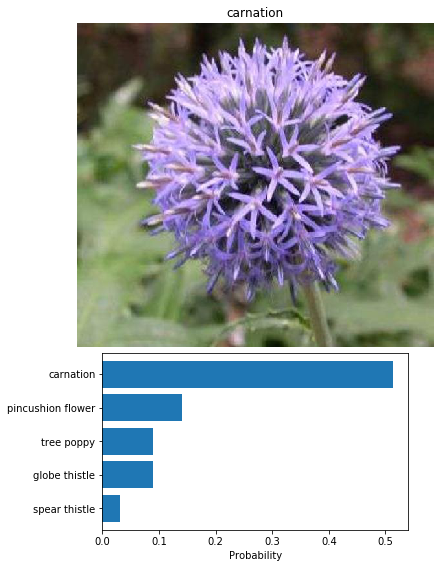

In [29]:
max_index = np.argmax(probabilities)
max_probability = probabilities[max_index]
label = classes[max_index]

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((15,9), (0,0),
                       colspan=9,
                       rowspan=9)
ax2 = plt.subplot2grid((15,9),
                       (9,2),
                       colspan=5,
                       rowspan=5)

image = Image.open(image_path)
ax1.axis('off')
ax1.set_title(cat_to_name[label])
ax1.imshow(image)
labels = []
for i_class in classes:
    labels.append(cat_to_name[i_class])
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()
ax2.set_xlabel('Probability')
ax2.barh(y_pos,
         probabilities,
         xerr=0,
         align='center')

plt.show()